# Treinamento regressão

In [1]:
treinar = {
    'GP': False,
    'RegressaoLinear': True,
    'BayesianLinearRegression': True,
    'BayesianPolinomialLinearRegression': True,
    'RBFLinearRegression': True,
}

In [2]:
# Métrica da otimização bayesiana
# Selecione: rmse, nlpd
metrica = 'rmse'
#metrica = 'nlpd'

## Conjunto de dados

In [3]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('housesToRentProcessed.csv', index_col=0)

X = dataset[[
    'São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas', 'Belo Horizonte', 
    'area',
    'rooms', 'bathroom', 'parking spaces', 'floor', 'isHouse', 'animal', 'furniture',
]].values
y = dataset[['y con + alu']].values

### Descrição do conjunto de dados

| Atributo         | Descrição                                           | Valor  |
| ---------------- | --------------------------------------------------- | ------ |
| `São Paulo`      | Imóvel está localizado na cidade de São Paulo?      | `int: 0 false - 1 true` |
| `Porto Alegre`   | Imóvel está localizado na cidade de Porto Alegre?   | `int: 0 false - 1 true` |
| `Rio de Janeiro` | Imóvel está localizado na cidade de Rio de Janeiro? | `int: 0 false - 1 true` |
| `Campinas`       | Imóvel está localizado na cidade de Campinas?       | `int: 0 false - 1 true` |
| `Belo Horizonte` | Imóvel está localizado na cidade de Belo Horizonte? | `int: 0 false - 1 true` |
| `area`           | Área do imóvel (em metros quadrados)                | `float` |
| `rooms`          | Quantidade de quartos                               | `int` |
| `bathroom`       | Quantidade de banheiros                             | `int` |
| `floor`          | Andar localizado o imóvel                           | `int`. `0` pressuposto para casa |
| `isHouse`        | Imóvel corresponde a um aluguel de casa             | `int: 0 false - 1 true` |
| `animal`         | É possivel levar animais para o imóvel              | `int: 0 false - 1 true` |
| `furniture`      | Se a casa já vem mobiliada                          | `int: 0 false - 1 true` |
| `y con + alu`    | Valor mensal total do aluguel do imóvel: aluguel + taxa de condomínio. | `float` |

In [4]:
dataset.head()

,São Paulo,Porto Alegre,Rio de Janeiro,Campinas,Belo Horizonte,area,rooms,bathroom,parking spaces,floor,isHouse,animal,furniture,y con + alu
3489,0,0,0,1,0,69,2,2,1,14,0,1,0,2125
669,1,0,0,0,0,450,4,5,6,1,1,1,0,12000
6003,0,0,0,0,1,61,3,1,1,2,0,1,0,1800
5333,1,0,0,0,0,54,2,2,1,2,0,1,0,2327
1524,0,0,0,1,0,85,3,2,1,7,0,1,0,2415


### Separação de treino e teste

Os dados foram separados em treino e em teste seguindo a proporção de $70\%$ para treino e de $30\%$ para testes. O processo de seleção do modelo será descrito posteriormente.

In [5]:
from sklearn.model_selection import train_test_split

# FIXME: Separar respeitando a proproção em cada cidade
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#X_train = X_train[:5]
#y_train = y_train[:5]

print('Quantidade de elementos para o treinamento:', X_train.shape)
print('Quantidade de elementos selecionados para teste:', X_test.shape)

Quantidade de elementos para o treinamento: (7481, 13)
Quantidade de elementos selecionados para teste: (3207, 13)


### Normalização

A normalização aplicada no conjunto de dados foi a [min/max scalling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler):
\begin{aligned}
\mathcal{D}_{std} &= \frac{\mathcal{D} - \mathcal{D}.min(axis=0)}{\mathcal{D}.max(axis=0) - \mathcal{D}.min(axis=0)}; \\
\mathcal{D}_{scaled} &= \mathcal{D}_{std} \cdot (max - min) + min.
\end{aligned}
A transformação aplicada, escala (dimensiona) e translada cada característica individualmente, de modo que esta esteja entre o intervalo $[0, 1]$.

Como poderá ser visto adiante, este trabalho tomou o cuidado dos dados de validação e de teste serem transformados conforme os dados  a escala definida no treinamento.

In [6]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler

## Treinamento

Com o intuito de selecionar os melhores hiperparâmetros, para cada um dos modelo testados, foi realizado uma validação cruzada por meio de _5-folds_, onde ocorreu uma otimização bayesiana em cada um dos _folds_. Os hiperparâmetros foram selecionados de acordo com o resultado da métrica **DECIDIR**, descrita adiante neste trabalho.

Após a seleção dos hiperparâmetros, cada um dos modelos foram avaliados com conjunto de testes por meio das métricas descritas a seguir.

### Métricas

#### Root Mean Squared Error (RMSE)

__Root Mean Squared Error__ ou raiz do erro quadrático médio [_terminar_]

\begin{aligned}
\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \frac{1}{N_\text{teste}} \sum_{i=1}^{N_\text{teste}} (y_i - \hat{y}_i)^2; \\
\text{RMSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \sqrt{\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}})}
\end{aligned}

In [7]:
from trabalho.util.metrica import rmse

#### Negative Log Predictive Density (NLPD)

A métrica **Negative Log Predictive Density** (NLPD) leva em consideração a variância predita $\hat{\sigma}_i^2$, além dos valores esperados e preditos (média):

\begin{aligned}
\text{NLPD}
&= -\frac{1}{N_\text{teste}}
    \sum_{i=1}^{N_\text{teste}}
    \log 
    \overbrace{p(y_i|\boldsymbol{x}_i, \boldsymbol{y}, \boldsymbol{X}, \hat{\boldsymbol{\theta}})}^{\mathcal{N}(y_i|\hat{\mu}_i, \hat{\sigma}_i^2)}
    \\
&= \frac{1}{2}\log2\pi + \frac{1}{2 N_\text{teste}}
\sum_{i=1}^{N_\text{teste}} \left[\log \hat{\sigma}^2_i + \frac{(y_i - \hat{\mu}_i)^2}{\hat{\sigma}^2_i}\right]
\end{aligned}

Conforme já discutido em aula, a NLPD busca realçar modelos equilibrandos, penalizando:
* modelos muito confiantes nos casos de erros grandes ($\sigma^2_i$ baixos para erros maiores), e;
* modelos pouco confiantes nos casos de erros pequenos ($\sigma^2_i$ altos para erros menores).

In [8]:
from trabalho.util.metrica import nlpd

## Modelos utilizados

In [9]:
relatorio_modelos = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold'])

### Processos Gaussianos

In [10]:
from trabalho.modelos.gp import GP

GP

trabalho.modelos.gp.GP

#### Hiperparâmetros a serem procurados

In [11]:
from trabalho.util.otimizacao_bayesiana import Dominio
import gpflow


kernels = [
    # Combinação de kernels
    #gpflow.kernels.Combination(),
    #gpflow.kernels.ChangePoints(),
    #gpflow.kernels.Product(),
    #gpflow.kernels.Sum(),
    
    # Imagem (convolução)
    #gpflow.kernels.Convolutional(),
    
    # Dados estacionários
    #gpflow.kernels.Stationary(),
    #gpflow.kernels.Periodic(), # Can be used to wrap any Stationary kernel to transform it into a periodic version
    #gpflow.kernels.AnisotropicStationary(), 
    #gpflow.kernels.IsotropicStationary(),
    
    # Multi objetivo
    #gpflow.kernels.MultioutputKernel(),
    #gpflow.kernels.IndependentLatent(),
    #gpflow.kernels.LinearCoregionalization(),
    #gpflow.kernels.SeparateIndependent(),
    #gpflow.kernels.SharedIndependent(),
    
    # Outros exóticos
    #gpflow.kernels.Coregion(),
    
    # Ok
    #gpflow.kernels.Kernel(), # Classe base
    #gpflow.kernels.Static(), # Classe base
    
    #gpflow.kernels.ArcCosine(),
    #gpflow.kernels.Constant(),
    #gpflow.kernels.Cosine(),
    #gpflow.kernels.Exponential(),
    #gpflow.kernels.Linear(),
    
    gpflow.kernels.Matern12(),
    gpflow.kernels.Matern32(),
    gpflow.kernels.Matern52(),
    
    #gpflow.kernels.Polynomial(),
    gpflow.kernels.SquaredExponential(), # RBF
    #gpflow.kernels.RationalQuadratic(),
    
    #gpflow.kernels.White(),
]


means = [
    # Padrão
    gpflow.mean_functions.Zero(),
    # Média
    gpflow.mean_functions.Linear(),
]

dominio_gp = Dominio([
    # https://gpflow.readthedocs.io/en/master/gpflow/kernels/#gpflow-kernels-linear
    {
        'name': 'kernel',
        'type': 'categorical',
        'domain': kernels
    },
    {
        'name': 'mean_function',
        'type': 'categorical',
        'domain': means
    },
#     {'name': 'learning_rate',   'type': 'continuous', 'domain': (0.0001, 0.02)},
#     {'name': 'sampling_method', 'type': 'discrete',   'domain': (1, 3, 5)},
#     {'name': 'regularization',  'type': 'continuous', 'domain': (0.00001, 0.01)},
#     {'name': 'batch_size',      'type': 'discrete',   'domain': (10, 16, 32)},
])

dominio_gp.dominio

[{'name': 'kernel', 'type': 'categorical', 'domain': [0, 1, 2, 3]},
 {'name': 'mean_function', 'type': 'categorical', 'domain': [0, 1]}]

### Regressão Linear

#### Regressão Linear (não bayesiana)

In [12]:
from trabalho.modelos.regressao_linear import RegressaoLinear

RegressaoLinear

trabalho.modelos.regressao_linear.RegressaoLinear

##### Hiperparâmetros a serem procurados

In [13]:
dominio_regressao_linear = Dominio([])

#### Regressão Linear Bayesiana

In [14]:
from trabalho.modelos.bayesian_linear_regression import BayesianLinearRegression

BayesianLinearRegression

trabalho.modelos.bayesian_linear_regression.BayesianLinearRegression

##### Hiperparâmetros a serem procurados

In [15]:
dominio_regressao_linear_bayesiana = Dominio([
    {
        'name': 'alphaInit',
        'type': 'continuous',
        'domain': (1e-7, 1.1)
    },
    {
        'name': 'lambdaInit',
        'type': 'continuous',
        'domain': (1e-7, 1.1)
    }
])

#### Regressão Linear Bayesiana Polinomial

In [16]:
from trabalho.modelos.bayesian_polinomial_linear_regression import BayesianPolinomialLinearRegression

BayesianPolinomialLinearRegression

trabalho.modelos.bayesian_polinomial_linear_regression.BayesianPolinomialLinearRegression

##### Hiperparâmetros a serem procurados

In [17]:
dominio_regressao_linear_bayesiana_polinomial = Dominio([
    {
        'name': 'alphaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'lambdaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'order',
        'type': 'discrete',
        'domain': (2, 3, 4, 5, 6, 7, 8, 9, 10)
    }
])

#### Regressão Linear Bayesiana com kernel RBF

In [18]:
from trabalho.modelos.rbf_linear_regression import RBFLinearRegression

RBFLinearRegression

trabalho.modelos.rbf_linear_regression.RBFLinearRegression

##### Hiperparâmetros a serem procurados

In [19]:
dominio_regressao_linear_bayesiana_rbf = Dominio([
#     {
#         'name': 'm0',
#         'type': 'continuous',
#         'domain': (0.0001, 1.1)
#     },
#     {
#         'name': 'S0',
#         'type': 'continuous',
#         'domain': (0.0001, 1.1)
#     },
    {
        'name': 'sig2_error',
        'type': 'continuous',
        'domain': (1e-7, 1)
    },
    {
        'name': 'mean_rbf_arbitrario',
        'type': 'continuous',
        'domain': (-1, 1)
    },
    {
        'name': 'lambda_rbf_arbitrario',
        'type': 'continuous',
        'domain': (1e-7, 1)
    }
])

### Validação - Seleção de modelos

In [20]:
from trabalho.util.kfold import KFoldCrossValidation
from GPyOpt.methods import BayesianOptimization
from tqdm import tqdm


def f(Modelo, X, y, metrica, k_folds, relatorio_geral, **kwargs):
    relatorio_parcial = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold', 'tentativa'])
    
    for fold, X_train, X_validation, y_train, y_validation in tqdm(KFoldCrossValidation(X, y, k_folds).split(), total=k_folds, desc="k-fold"):
        resultado = treinar_modelo(Modelo, X_train, X_validation, y_train, y_validation, **kwargs)
        
        total_execucoes = len(relatorio_geral)
        tentativa = (total_execucoes - total_execucoes % k_folds) / k_folds
        
        relatorio_parcial.loc[len(relatorio_parcial)] = resultado + [fold, tentativa]
        relatorio_geral.loc[total_execucoes] = resultado + [fold, tentativa]


    medias = relatorio_parcial.mean()
    
    # Fixme: juntar com o relatório final
    #relatorio_parcial
    
    return medias[metrica]


def treinar_modelo(Modelo, X_train, X_validation, y_train, y_validation, **kwargs):
    X_scaler = Scaler()
    y_scaler = Scaler()

    X_train_transform      = X_scaler.fit_transform(X_train)
    X_validation_transform = X_scaler.transform(X_validation)
    y_train_transform      = y_scaler.fit_transform(y_train)
    y_validation_transform = y_scaler.transform(y_validation)

    modelo = Modelo(**kwargs)
    modelo.fit(X_train_transform, y_train_transform)

    means, vars = modelo.predict(X_validation_transform)
    means = means.reshape((-1, 1))

    means_dimensao_correta = y_scaler.inverse_transform(means)
    #vars_dimensao_correta = # Perguntar ao Madson
    vars_dimensao_correta = vars

    erro_rmse = rmse(means_dimensao_correta, y_validation)
    erro_nlpd = nlpd(means_dimensao_correta, vars_dimensao_correta, y_validation)
    
    return [Modelo.__name__, kwargs, erro_rmse, erro_nlpd]


def otimizacao_bayesiana(Modelo, dominio, X, y, k_folds=5, metrica='rmse'):
    relatorio = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold', 'tentativa'])
    funcao = dominio.gerar_f(Modelo=Modelo, f=f, X=X, y=y, k_folds=5, metrica=metrica, relatorio_geral=relatorio)

    bo = BayesianOptimization(f=funcao, domain=dominio.dominio, verbosity=True)
    bo.run_optimization(max_iter=50)

    try:
        bo.plot_convergence()
        bo.plot_acquisition()
    except Exception as e:
        print(e)

    print('RMSE:', bo.fx_opt)
    print('Parâmetros:', bo.x_opt)

    return relatorio

In [21]:
modelos = {
    'GP': (GP, dominio_gp),
    'RegressaoLinear': (RegressaoLinear, dominio_regressao_linear),
    'BayesianLinearRegression': (BayesianLinearRegression, dominio_regressao_linear_bayesiana),
    'BayesianPolinomialLinearRegression': (BayesianPolinomialLinearRegression, dominio_regressao_linear_bayesiana_polinomial),
    'RBFLinearRegression': (RBFLinearRegression, dominio_regressao_linear_bayesiana_rbf),
}

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

GP False
RegressaoLinear True


k-fold: 100%|██████████| 5/5 [00:00<00:00, 48.94it/s]


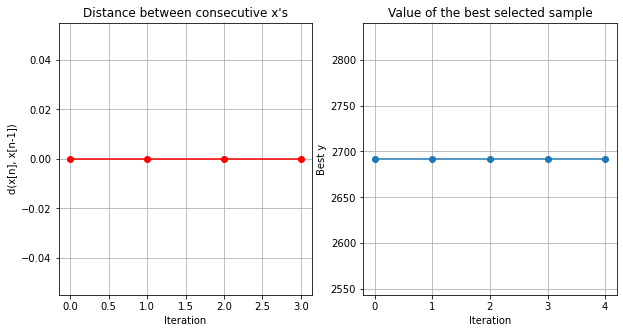

k-fold:  20%|██        | 1/5 [00:00<00:00,  5.63it/s]

not enough values to unpack (expected 2, got 0)
RMSE: 2691.8796235533614
Parâmetros: []
BayesianLinearRegression True


k-fold: 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]


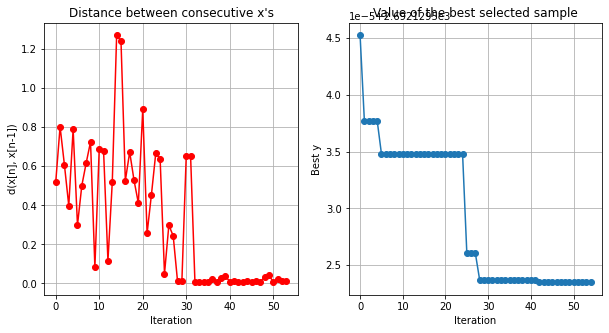

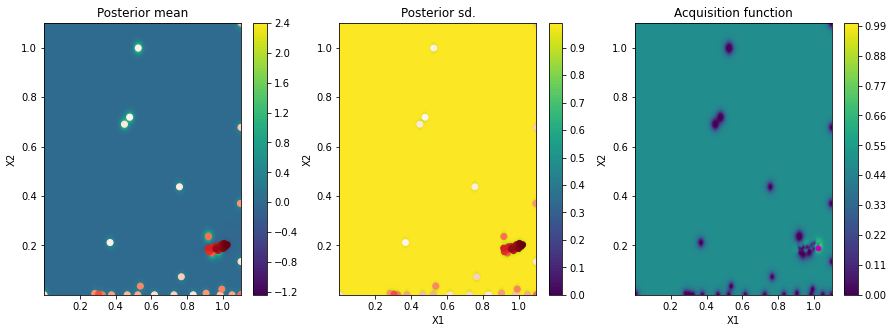

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

RMSE: 2692.1295234728013
Parâmetros: [0.96474184 0.1846786 ]
BayesianPolinomialLinearRegression True


k-fold: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


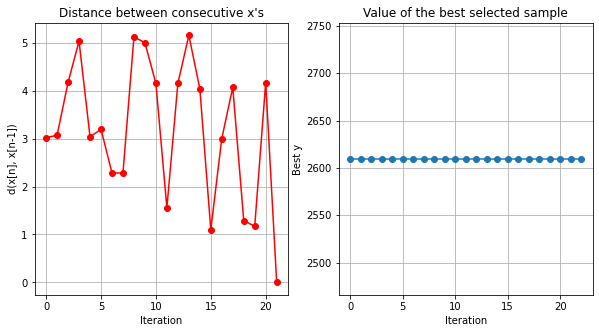

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

RMSE: 2609.5225164465005
Parâmetros: [0.80674505 0.90237157 7.        ]
RBFLinearRegression True


k-fold: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


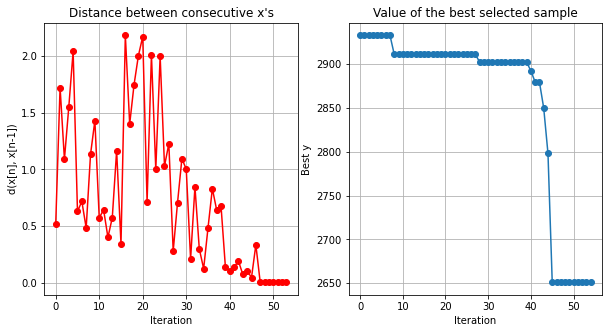

RMSE: 2650.9405635772937
Parâmetros: [ 0.55182664 -1.          0.03325333]


In [22]:
relatorio_modelos = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold', 'tentativa'])


for modelo, (Classe, dominio) in modelos.items():
    print(modelo, treinar[modelo])
    if treinar[modelo]:
        resultado_parcial = otimizacao_bayesiana(Modelo=Classe, dominio=dominio, X=X_train, y=y_train, metrica=metrica)
        relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])
        resultado_parcial.to_csv(f'resultados/parciais/{modelo}_{metrica}.csv')

#### Resultado prelimiar

In [23]:
relatorio_condensado = \
relatorio_modelos.groupby(['modelo', 'tentativa']) \
                  .agg(['mean', 'std']) \
                  .reset_index() \
                  .sort_values(by=(metrica, 'mean')) \
                  .groupby('modelo').first()

relatorio_condensado

tentativa         rmse              \
                                                     mean         std   
modelo                                                                  
BayesianLinearRegression                42.0  2692.129523  289.391808   
BayesianPolinomialLinearRegression       0.0  2609.522516  309.431265   
RBFLinearRegression                     45.0  2650.940564  304.852284   
RegressaoLinear                          3.0  2691.879624  289.746142   

                                            nlpd                
                                            mean           std  
modelo                                                          
BayesianLinearRegression            2.858466e+09  7.494464e+08  
BayesianPolinomialLinearRegression  2.846606e+09  7.158806e+08  
RBFLinearRegression                 1.605219e+06  3.905029e+05  
RegressaoLinear                     3.656689e+66  8.322313e+65

### Resultado Final

In [24]:
melhores_hiperparametros = {}

for modelo, tentativa in relatorio_condensado[['tentativa']].reset_index().values:
    resultado = (relatorio_modelos.modelo == modelo) & (relatorio_modelos.tentativa == tentativa)
    melhores_hiperparametros[modelo] = relatorio_modelos[resultado].parametros.values[0]

pd.DataFrame(melhores_hiperparametros)

,BayesianLinearRegression,BayesianPolinomialLinearRegression,RBFLinearRegression,RegressaoLinear
alphaInit,0.964742,0.806745,NaN,NaN
lambdaInit,0.184679,0.902372,NaN,NaN
order,NaN,7.000000,NaN,NaN
sig2_error,NaN,NaN,0.551827,NaN
mean_rbf_arbitrario,NaN,NaN,-1.000000,NaN
lambda_rbf_arbitrario,NaN,NaN,0.033253,NaN


In [27]:
relatorio_final = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd'])


for i, (modelo, hiperparametros) in tqdm(enumerate(melhores_hiperparametros.items())):
    Modelo, dominio = modelos[modelo]
    resultado = treinar_modelo(Modelo, X_train, X_test, y_train, y_test, **hiperparametros)
                                         
    relatorio_final.loc[i] = resultado
    

# # Calcular valor do RMSE do y na dimensão original
# relatorio['rmse_dimensao_original'] = y_scaler.inverse_transform(relatorio.rmse.values.reshape((-1, 1)))

# # Nome do arquivo
# nomes_modelos = relatorio.modelo.unique()
# nomes_modelos.sort()

# nome_arquivo = f'resultados/final/{fold_externo}_{metrica}_{"-".join(nomes_modelos)}.csv'
# relatorio.to_csv(nome_arquivo)
relatorio_final

4it [00:02,  1.96it/s]


,modelo,parametros,rmse,nlpd
0,BayesianLinearRegression,"{'alphaInit': 0.9647418428875216, 'lambdaInit'...",1.162060e+04,6.697594e+10
1,BayesianPolinomialLinearRegression,"{'alphaInit': 0.8067450492515083, 'lambdaInit'...",2.610644e+12,3.599954e+27
2,RBFLinearRegression,"{'sig2_error': 0.5518266361880085, 'mean_rbf_a...",2.483575e+03,1.394763e+06
3,RegressaoLinear,{},1.176309e+04,6.918516e+67
